# Anomaly Record Detection in Sequence Data using Support Vector Machines -  Yahoo Data (Univariate)

In [75]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import import_ipynb
from Deviation_Threshold import get_deviations, get_anomaly_labels_by_deviation_threshold, get_anomaly_labels_by_deviation_pctile_threshold
import glob
from sklearn.metrics import precision_recall_fscore_support
import warnings
import statistics
from tabulate import tabulate
warnings.filterwarnings('ignore')

%matplotlib inline


In [52]:
def predictTimeSeries(file_path, sliding_window=1, threshold=0.1, asPercentile=True, percentile=75.0, kernel='rbf', epsilon=0.1, gamma='scale', C=1.0):
    """
    This function reads in csv's in the given path and processes each of them, based on the sliding window.
    Creates a Support Vector Regression Model and fits 80% of the data and predicts 20% of the data
    
    file_path - path to the csv files
    sliding_window - how many previous entries should be considered as inputs to the current entry
    
    return - dictionary of precision, recall and F1-scores for each csv file
             Ex: {key,value} --> {fileName, [precision, recall, f1-score]}
    """
    
    dict={}

    a1_csv = glob.glob(file_path, recursive=True)
    for index,file in enumerate(a1_csv):

        # Read in 1 csv file
        yahoo_df = pd.read_csv(file)
        fname = file.split("/")[4].replace('\\','').split(".")[0]
#         print("File name {}".format(fname))
        # Extract column names
        columnNames = list(yahoo_df.columns)

        # Make a copy of the dataframe, one will be used as output, and the other as input
        yahoo_df_copy = yahoo_df.copy(deep=True)

        # first append a NaN row to the dataframe, because the last row will be lost when shifted
        yahoo_df_copy = yahoo_df_copy.append(pd.Series(), ignore_index=True)
        yahoo_df_copy = yahoo_df_copy.shift(1)

    #     print("Copy head")
    #     print(yahoo_df_copy.head(5))

        # a NaN row is required to be able to merge
        yahoo_df = yahoo_df.append(pd.Series(), ignore_index=True)

    #     print("Original head")
    #     print(yahoo_df.head(5))

        yahoo_df = yahoo_df.rename(columns=createColumnDict(columnNames))

        yahoo_merged = yahoo_df_copy.merge(yahoo_df, left_index=True, right_index=True)

    #     print("Merged head")
    #     print(yahoo_merged.head(5))

    #     print("Merged tail")
    #     print(yahoo_merged.tail(5))

    #     print(yahoo_merged.shape)
    #     print(yahoo_merged.head(0))

        # TODO put this in a for loop for sliding_window > 1
        last_index = yahoo_merged.shape[0] - 1
        # drop the 1st and last rows, because they contain NaN values
        yahoo_merged = yahoo_merged.drop([0,last_index])
        
#         yahoo_merged = yahoo_merged.drop(['is_anomaly','is_anomaly_y','timestamp', 'timestamp_y'], axis=1)
        train_size = int(len(yahoo_merged) * 0.8)
        train_set, test_set = yahoo_merged[:train_size], yahoo_merged[train_size:]
        #seperate into features and target
        X_train = train_set[['value']]
        y_train = train_set[['value_y']]
        X_test = test_set[['value']]
        y_test = test_set[['value_y']]
        
        # outlier_y column is not needed for forecasting, but needed later to detect outliers
        outlier_df = test_set[['is_anomaly_y']]

        svm_clf = SVR(kernel=kernel,gamma=gamma,C=C, epsilon=epsilon)
        svm_clf.fit(X_train, np.ravel(y_train))
        y_predict = svm_clf.predict(X_test)
#         y_predict1 = y_predict.reshape(-1,1)

#         print("Actual anomaly : ")
#         print(outlier_df)

        predicted_anomaly = None
        if(asPercentile):
            predicted_anomaly = get_anomaly_labels_by_deviation_pctile_threshold(np.ravel(y_test), np.ravel(y_predict), percentile) 
        else:
            predicted_anomaly = get_anomaly_labels_by_deviation_threshold(np.ravel(y_test), np.ravel(y_predict), threshold)
        
        metrics = precision_recall_fscore_support(np.ravel(outlier_df), predicted_anomaly, average='binary', zero_division=0)
        
        # metrics[0] is Precision, metrics[1] is Recall and metrics[2] is F1-score
        dict[fname] = [metrics[0], metrics[1], metrics[2]]
#         print("Precision :" ,metrics[0], "Recall :", metrics[1], "F1-score :" ,metrics[2])
#         print()
    return dict


In [53]:
def createColumnDict(columnNames):
    """
    Generates a dictionary which contains a mapping between column names to the target column names
    
    columnNames - current names of the columns
    
    return a dictionary which contains a mapping between column names
            Ex: ["timestamp", "value", "is_anomaly"]
            {"timestamp": "timestamp_y", "value": "value_y", "is_anomaly": "is_anomaly_y"}
    """
    
    dict = {}
    for name in columnNames:
        dict[name] = name + "_y"
    
    return dict

In [54]:
def getMetricResults(dictionary):
    """
    Reads data from the dictionary and generates a list of required measure
    
    dictionary - dictionary containing key, value pairs of filename and metric list
    
    returns 3 lists of each metric values
    """

    precision_results = []
    for fname in dictionary:
        all_results = dictionary[fname]
        precision_results.append(all_results[0])
        
    recall_results = []
    for fname in dictionary:
        all_results = dictionary[fname]
        recall_results.append(all_results[1])
        
    f1_results = []
    for fname in dictionary:
        all_results = dictionary[fname]
        f1_results.append(all_results[2])
    
    return precision_results, recall_results, f1_results
    

In [67]:
def draw_box_plots(p1, p2, p3, r1, r2, r3, f1, f2, f3, p1_n, p2_n, p3_n, r1_n, r2_n, r3_n, f1_n, f2_n, f3_n):

    """
    Takes in 18 lists (6 precision results lists, 6 recall results lists, 6 f1-score results lists) and plots
    6 boxplots, each having 3 box plots
    """
    
    precision_data = [p1, p2, p3] 
    recall_data = [r1, r2, r3] 
    f1_data = [f1, f2, f3] 

    new_precision_data = [p1_n, p2_n, p3_n]
    new_recall_data = [r1_n, r2_n, r3_n]
    new_f1_data = [f1_n, f2_n, f3_n]

    fig, ax = plt.subplots(3, 2, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.4, wspace=0.7)

    ax[0][0].set_title('SVR when epsilon="0.1"')
    ax[0][0].set_xlabel('C')
    ax[0][0].set_ylabel('Precision')
    ax[0][0].set_xticklabels([1,25,50])
    ax[0][0].boxplot(precision_data)

    ax[0][1].set_title('SVR when epsilon="0.5"')
    ax[0][1].set_xlabel('C')
    ax[0][1].set_ylabel('Precision')
    ax[0][1].set_xticklabels([1,25,50])
    ax[0][1].sharey(ax[0, 0])
    ax[0][1].boxplot(new_precision_data)

    ax[1][0].set_xlabel('C')
    ax[1][0].set_ylabel('Recall')
    ax[1][0].set_xticklabels([1,25,50])
    ax[1][0].boxplot(recall_data)
    
    ax[1][1].set_xlabel('C')
    ax[1][1].set_ylabel('Recall')
    ax[1][1].set_xticklabels([1,25,50])
    ax[1][1].sharey(ax[1, 0])
    ax[1][1].boxplot(new_recall_data)

    ax[2][0].set_xlabel('C')
    ax[2][0].set_ylabel('F1-score')
    ax[2][0].set_xticklabels([1,25,50]) 
    ax[2][0].boxplot(f1_data)
    
    ax[2][1].set_xlabel('C')
    ax[2][1].set_ylabel('F1-score')
    ax[2][1].set_xticklabels([1,25,50]) 
    ax[2][1].sharey(ax[2, 0])
    ax[2][1].boxplot(new_f1_data)

    plt.show()

In [81]:
def generate_median_table(p1, p2, p3, r1, r2, r3, f1, f2, f3, p1_n, p2_n, p3_n, r1_n, r2_n, r3_n, f1_n, f2_n, f3_n):
    """
    Generates 2 tables which includes the median of precision, recall and f1-score results
    First 9 lists belong in 1 table and the other 9 lists belong the other table
    
    """
    
    l1 = [['precision', statistics.median(p1), statistics.median(p2), statistics.median(p3)],
          ['recall', statistics.median(r1), statistics.median(r2), statistics.median(r3)],
          ['f1-score', statistics.median(f1), statistics.median(f2), statistics.median(f3)]]
    table1 = tabulate(l1, headers=['', 'C=1', 'C=25', 'C=50' ], tablefmt='orgtbl')
    print()
    print('Median when SVR has epsilon="0.1"\n')
    print(table1)
    
    l2 = [['precision', statistics.median(p1_n), statistics.median(p2_n), statistics.median(p3_n)],
          ['recall', statistics.median(r1_n), statistics.median(r2_n), statistics.median(r3_n)],
          ['f1-score', statistics.median(f1_n), statistics.median(f2_n), statistics.median(f3_n)]]
    table2 = tabulate(l2, headers=['', 'C=1', 'C=25', 'C=50' ], tablefmt='orgtbl')
    print()
    print('Median when SVR has epsilon="0.5"\n')
    print(table2)


### A1 Benchmark

In [56]:
A1_dict_default = predictTimeSeries('./data/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark_processed/*.csv',1)
A1_dict_C_1_5 = predictTimeSeries('./data/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark_processed/*.csv',1,C=25)
A1_dict_C_2_0 = predictTimeSeries('./data/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark_processed/*.csv',1,C=50)
A1_dict_gamma_auto = predictTimeSeries('./data/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark_processed/*.csv',1, epsilon=0.5)
A1_dict_g_auto_C_1_5 = predictTimeSeries('./data/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark_processed/*.csv',1,epsilon=0.5, C=25)
A1_dict_g_auto_C_2_0 = predictTimeSeries('./data/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark_processed/*.csv',1,epsilon=0.5, C=50)

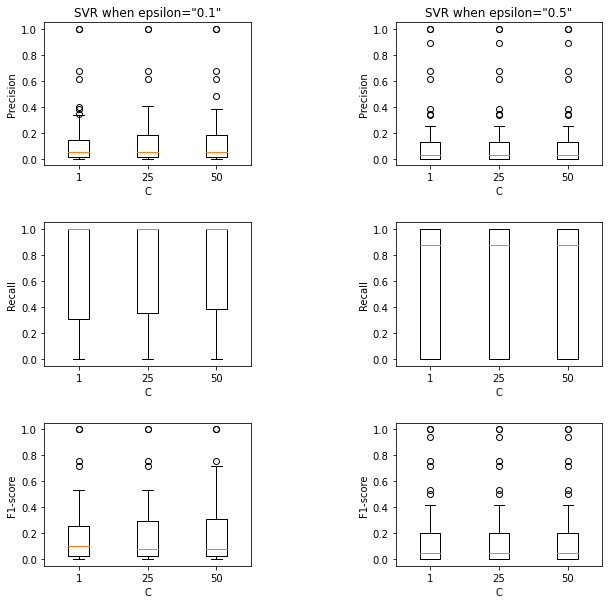

In [82]:
# results for epsilon = 0.1
a1_p1, a1_r1, a1_f1 = getMetricResults(A1_dict_default)
a1_p2, a1_r2, a1_f2 = getMetricResults(A1_dict_C_1_5)
a1_p3, a1_r3, a1_f3 = getMetricResults(A1_dict_C_2_0)

# results for epsilon = 0.5
a1_p1_n, a1_r1_n, a1_f1_n = getMetricResults(A1_dict_gamma_auto)
a1_p2_n, a1_r2_n, a1_f2_n = getMetricResults(A1_dict_g_auto_C_1_5)
a1_p3_n, a1_r3_n, a1_f3_n = getMetricResults(A1_dict_g_auto_C_2_0)

draw_box_plots(a1_p1, a1_p2, a1_p3, a1_r1, a1_r2, a1_r3, a1_f1, a1_f2, a1_f3, a1_p1_n, a1_p2_n, a1_p3_n, a1_r1_n, a1_r2_n, a1_r3_n, a1_f1_n, a1_f2_n, a1_f3_n)

In [83]:
generate_median_table(a1_p1, a1_p2, a1_p3, a1_r1, a1_r2, a1_r3, a1_f1, a1_f2, a1_f3, a1_p1_n, a1_p2_n, a1_p3_n, a1_r1_n, a1_r2_n, a1_r3_n, a1_f1_n, a1_f2_n, a1_f3_n)


Median when SVR has epsilon="0.1"

|           |       C=1 |      C=25 |      C=50 |
|-----------+-----------+-----------+-----------|
| precision | 0.0555556 | 0.0555556 | 0.0555556 |
| recall    | 1         | 1         | 1         |
| f1-score  | 0.1       | 0.0789474 | 0.0789474 |

Median when SVR has epsilon="0.5"

|           |       C=1 |      C=25 |      C=50 |
|-----------+-----------+-----------+-----------|
| precision | 0.028169  | 0.028169  | 0.028169  |
| recall    | 0.875     | 0.875     | 0.875     |
| f1-score  | 0.0493827 | 0.0493827 | 0.0493827 |


### A2 Benchmark

In [59]:
A2_dict_default = predictTimeSeries('./data/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark_processed/*.csv',1)
A2_dict_C_1_5 = predictTimeSeries('./data/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark_processed/*.csv',1,C=25)
A2_dict_C_2_0 = predictTimeSeries('./data/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark_processed/*.csv',1,C=50)
A2_dict_gamma_auto = predictTimeSeries('./data/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark_processed/*.csv',1, epsilon=0.5)
A2_dict_g_auto_C_1_5 = predictTimeSeries('./data/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark_processed/*.csv',1, epsilon=0.5, C=25)
A2_dict_g_auto_C_2_0 = predictTimeSeries('./data/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark_processed/*.csv',1, epsilon=0.5, C=50)

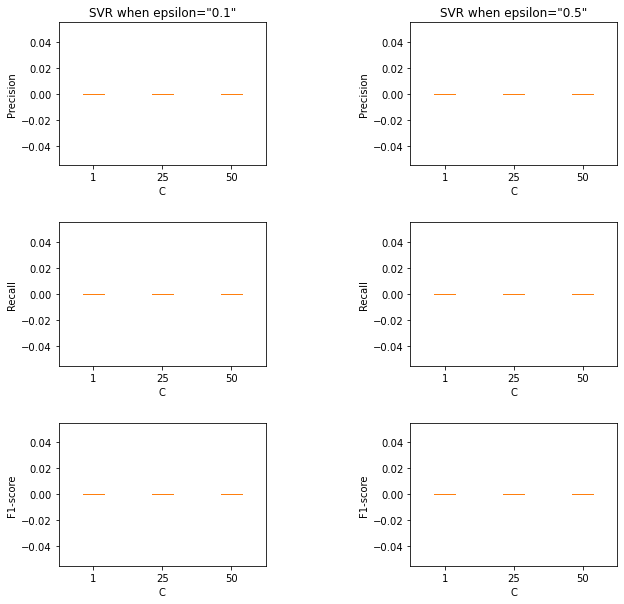

In [69]:
# results for epsilon = 0.1
a2_p1, a2_r1, a2_f1 = getMetricResults(A2_dict_default)
a2_p2, a2_r2, a2_f2 = getMetricResults(A2_dict_C_1_5)
a2_p3, a2_r3, a2_f3 = getMetricResults(A2_dict_C_2_0)

# results for epsilon = 0.5
a2_p1_n, a2_r1_n, a2_f1_n = getMetricResults(A2_dict_gamma_auto)
a2_p2_n, a2_r2_n, a2_f2_n = getMetricResults(A2_dict_g_auto_C_1_5)
a2_p3_n, a2_r3_n, a2_f3_n = getMetricResults(A2_dict_g_auto_C_2_0)

draw_box_plots(a2_p1, a2_p2, a2_p3, a2_r1, a2_r2, a2_r3, a2_f1, a2_f2, a2_f3, a2_p1_n, a2_p2_n, a2_p3_n, a2_r1_n, a2_r2_n, a2_r3_n, a2_f1_n, a2_f2_n, a2_f3_n)

In [84]:
generate_median_table(a2_p1, a2_p2, a2_p3, a2_r1, a2_r2, a2_r3, a2_f1, a2_f2, a2_f3, a2_p1_n, a2_p2_n, a2_p3_n, a2_r1_n, a2_r2_n, a2_r3_n, a2_f1_n, a2_f2_n, a2_f3_n)


Median when SVR has epsilon="0.1"

|           |   C=1 |   C=25 |   C=50 |
|-----------+-------+--------+--------|
| precision |     0 |      0 |      0 |
| recall    |     0 |      0 |      0 |
| f1-score  |     0 |      0 |      0 |

Median when SVR has epsilon="0.5"

|           |   C=1 |   C=25 |   C=50 |
|-----------+-------+--------+--------|
| precision |     0 |      0 |      0 |
| recall    |     0 |      0 |      0 |
| f1-score  |     0 |      0 |      0 |


There is a difference between the data in A1Benchmark and A2Benchmark compared to A3Benchmark and A4Benchmark. For example, more number of fields and anomaly fields

In [62]:
def predictTimeSeriesNew(file_path, sliding_window=1, threshold=0.1, asPercentile=True, percentile=75.0, gamma='scale', kernel='rbf', epsilon=0.1, C=1.0):
    """
    This function reads in csv's in the given path and processes each of them, based on the sliding window.
    Creates a Support Vector Regression Model and fits 80% of the data and predicts 20% of the data
    
    file_path - path to the csv files
    sliding_window - how many previous entries should be considered as inputs to the current entry
    
    return - dictionary of precision, recall and F1-scores for each csv file
    """

    dict = {}
    a3_csv = glob.glob(file_path, recursive=True)
    for index,file in enumerate(a3_csv):

        fname = file.split("/")[4].replace('\\','').split(".")[0]
        
        if(not(fname == 'A3Benchmark_all' or fname == 'A4Benchmark_all')):
        
            #print("File name {}".format(fname))
        
            # Read in 1 csv file
            yahoo_df = pd.read_csv(file)


            # these csv files have 9 attributes, but we need only 
            yahoo_df = yahoo_df[['timestamps','value','anomaly']]

            # Extract column names
            columnNames = list(yahoo_df.columns)

            # Make a copy of the dataframe, one will be used as output, and the other as input
            yahoo_df_copy = yahoo_df.copy(deep=True)

            # first append a NaN row to the dataframe, because the last row will be lost when shifted
            yahoo_df_copy = yahoo_df_copy.append(pd.Series(), ignore_index=True)
            yahoo_df_copy = yahoo_df_copy.shift(1)

        #     print("Copy head")
        #     print(yahoo_df_copy.head(5))

            # a NaN row is required to be able to merge
            yahoo_df = yahoo_df.append(pd.Series(), ignore_index=True)

        #     print("Original head")
        #     print(yahoo_df.head(5))

            yahoo_df = yahoo_df.rename(columns=createColumnDict(columnNames))

            yahoo_merged = yahoo_df_copy.merge(yahoo_df, left_index=True, right_index=True)

        #     print("Merged head")
        #     print(yahoo_merged.head(5))

        #     print("Merged tail")
        #     print(yahoo_merged.tail(5))

        #     print(yahoo_merged.shape)
        #     print(yahoo_merged.head(0))

            # TODO put this in a for loop for sliding_window > 1
            last_index = yahoo_merged.shape[0] - 1
            # drop the 1st and last rows, because they contain NaN values
            yahoo_merged = yahoo_merged.drop([0,last_index])

    #         yahoo_merged = yahoo_merged.drop(['is_anomaly','is_anomaly_y','timestamp', 'timestamp_y'], axis=1)
            train_size = int(len(yahoo_merged) * 0.8)
            train_set, test_set = yahoo_merged[:train_size], yahoo_merged[train_size:]
            #seperate into features and target
            X_train = train_set[['value']]
            y_train = train_set[['value_y']]
            X_test = test_set[['value']]
            y_test = test_set[['value_y']]

            # outlier_y column is not needed for forecasting, but needed later to detect outliers
            outlier_df = test_set[['anomaly_y']]

            svm_clf = SVR(kernel=kernel, gamma=gamma, C=C, epsilon=epsilon)
            svm_clf.fit(X_train, np.ravel(y_train))
            y_predict = svm_clf.predict(X_test)
    #         y_predict1 = y_predict.reshape(-1,1)

    #         print("Actual anomaly : ")
    #         print(outlier_df)

            predicted_anomaly = None
            if(asPercentile):
                predicted_anomaly = get_anomaly_labels_by_deviation_pctile_threshold(np.ravel(y_test), np.ravel(y_predict), percentile) 
            else:
                predicted_anomaly = get_anomaly_labels_by_deviation_threshold(np.ravel(y_test), np.ravel(y_predict), threshold)

            metrics = precision_recall_fscore_support(np.ravel(outlier_df), predicted_anomaly, average='binary', zero_division=0)

            dict[fname] = [metrics[0], metrics[1], metrics[2]]

    return dict



### A3 Benchmark

In [63]:
A3_dict_default = predictTimeSeriesNew('./data/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark_processed/*.csv',1)
A3_dict_C_1_5 = predictTimeSeriesNew('./data/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark_processed/*.csv',1,C=25)
A3_dict_C_2_0 = predictTimeSeriesNew('./data/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark_processed/*.csv',1,C=50)
A3_dict_g_auto = predictTimeSeriesNew('./data/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark_processed/*.csv',1,epsilon=0.5)
A3_dict_g_auto_C_1_5 = predictTimeSeriesNew('./data/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark_processed/*.csv',1,epsilon=0.5,C=25)
A3_dict_g_auto_C_2_0 = predictTimeSeriesNew('./data/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark_processed/*.csv',1,epsilon=0.5,C=50)

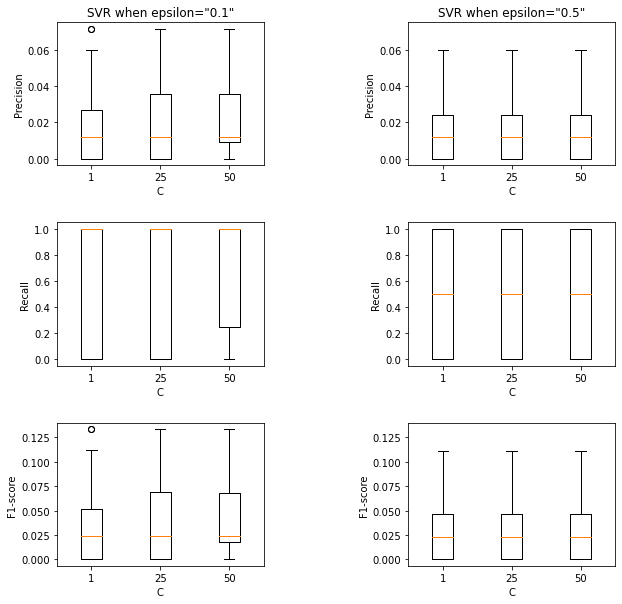

In [70]:
# results for epsilon = 0.1
a3_p1, a3_r1, a3_f1 = getMetricResults(A3_dict_default)
a3_p2, a3_r2, a3_f2 = getMetricResults(A3_dict_C_1_5)
a3_p3, a3_r3, a3_f3 = getMetricResults(A3_dict_C_2_0)

# results for epsilon = 0.5
a3_p1_n, a3_r1_n, a3_f1_n = getMetricResults(A3_dict_g_auto)
a3_p2_n, a3_r2_n, a3_f2_n = getMetricResults(A3_dict_g_auto_C_1_5)
a3_p3_n, a3_r3_n, a3_f3_n = getMetricResults(A3_dict_g_auto_C_2_0)

draw_box_plots(a3_p1, a3_p2, a3_p3, a3_r1, a3_r2, a3_r3, a3_f1, a3_f2, a3_f3, a3_p1_n, a3_p2_n, a3_p3_n, a3_r1_n, a3_r2_n, a3_r3_n, a3_f1_n, a3_f2_n, a3_f3_n)

In [85]:
generate_median_table(a3_p1, a3_p2, a3_p3, a3_r1, a3_r2, a3_r3, a3_f1, a3_f2, a3_f3, a3_p1_n, a3_p2_n, a3_p3_n, a3_r1_n, a3_r2_n, a3_r3_n, a3_f1_n, a3_f2_n, a3_f3_n)


Median when SVR has epsilon="0.1"

|           |       C=1 |      C=25 |      C=50 |
|-----------+-----------+-----------+-----------|
| precision | 0.0119048 | 0.0119048 | 0.0119048 |
| recall    | 1         | 1         | 1         |
| f1-score  | 0.0235294 | 0.0235294 | 0.0235294 |

Median when SVR has epsilon="0.5"

|           |       C=1 |      C=25 |      C=50 |
|-----------+-----------+-----------+-----------|
| precision | 0.0119048 | 0.0119048 | 0.0119048 |
| recall    | 0.5       | 0.5       | 0.5       |
| f1-score  | 0.0232558 | 0.0232558 | 0.0232558 |


### A4 Benchmark

In [65]:
A4_dict_default = predictTimeSeriesNew('./data/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark_processed/*.csv',1)
A4_dict_C_1_5 = predictTimeSeriesNew('./data/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark_processed/*.csv',1,C=25)
A4_dict_C_2_0 = predictTimeSeriesNew('./data/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark_processed/*.csv',1,C=50)
A4_dict_g_auto = predictTimeSeriesNew('./data/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark_processed/*.csv',1,epsilon=0.5)
A4_dict_g_auto_C_1_5 = predictTimeSeriesNew('./data/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark_processed/*.csv',1,epsilon=0.5, C=25)
A4_dict_g_auto_C_2_0 = predictTimeSeriesNew('./data/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark_processed/*.csv',1,epsilon=0.5, C=50)

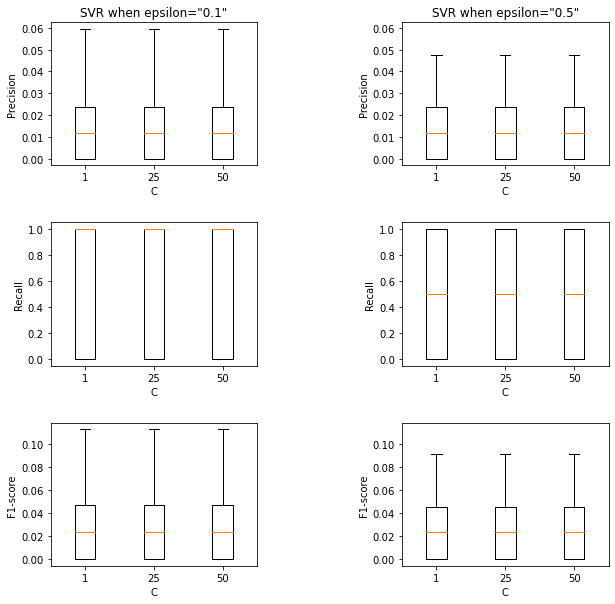

In [71]:
# results for epsilon = 0.1
a4_p1, a4_r1, a4_f1 = getMetricResults(A4_dict_default)
a4_p2, a4_r2, a4_f2 = getMetricResults(A4_dict_C_1_5)
a4_p3, a4_r3, a4_f3 = getMetricResults(A4_dict_C_2_0)

# results for epsilon = 0.5
a4_p1_n, a4_r1_n, a4_f1_n = getMetricResults(A4_dict_g_auto)
a4_p2_n, a4_r2_n, a4_f2_n = getMetricResults(A4_dict_g_auto_C_1_5)
a4_p3_n, a4_r3_n, a4_f3_n = getMetricResults(A4_dict_g_auto_C_2_0)

draw_box_plots(a4_p1, a4_p2, a4_p3, a4_r1, a4_r2, a4_r3, a4_f1, a4_f2, a4_f3, a4_p1_n, a4_p2_n, a4_p3_n, a4_r1_n, a4_r2_n, a4_r3_n, a4_f1_n, a4_f2_n, a4_f3_n)


In [86]:
generate_median_table(a4_p1, a4_p2, a4_p3, a4_r1, a4_r2, a4_r3, a4_f1, a4_f2, a4_f3, a4_p1_n, a4_p2_n, a4_p3_n, a4_r1_n, a4_r2_n, a4_r3_n, a4_f1_n, a4_f2_n, a4_f3_n)


Median when SVR has epsilon="0.1"

|           |       C=1 |      C=25 |      C=50 |
|-----------+-----------+-----------+-----------|
| precision | 0.0119048 | 0.0119048 | 0.0119048 |
| recall    | 1         | 1         | 1         |
| f1-score  | 0.0235294 | 0.0235294 | 0.0235294 |

Median when SVR has epsilon="0.5"

|           |       C=1 |      C=25 |      C=50 |
|-----------+-----------+-----------+-----------|
| precision | 0.0119048 | 0.0119048 | 0.0119048 |
| recall    | 0.5       | 0.5       | 0.5       |
| f1-score  | 0.0232558 | 0.0232558 | 0.0232558 |
